In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

import random
import copy

import pickle
from datetime import datetime

import scipy.stats as ss
from scipy.stats import norm
from scipy.stats import poisson
from scipy import spatial

# import code
from simulation import Simulation
from replicate_graph import layer_graph
import data
from data import select_dataset, get_station_g, set_random_speed_columns
from visualization import set_draw_attributes

import os

import re
from tqdm import tqdm

from mpl_toolkits.basemap import Basemap as Basemap


### Route Usage

Unpacking simulation run data to identify traffic along routes throughout the simulation period. 

In [62]:
fname = "wcctci_04_20_2022_10_10_02"
with open(f'trials/algorithm 3 iterations/{fname}.pkl', 'rb') as inp:
    res = pickle.load(inp)

Visualize node utilization, scaling nodes by their average number of cars at the station

In [42]:
# ## Add average utilization to the node data in station_G
# cars_avg = np.average(np.array(res.data["num_cars_at_station"]), axis=0)

# for node in res.station_g.nodes:
#     ind = int(node)-1
#     util = cars_avg[ind]
#     res.station_g.nodes[node]['utilization'] = util

In [43]:
# ## Plot 
# m = Basemap(
#         projection='merc',
#         llcrnrlon=-126 ,
#         llcrnrlat=31,
#         urcrnrlon=-113,
#         urcrnrlat=43,
#         lat_ts=0,
#         resolution='i',
#         suppress_ticks=True)

# fig = plt.subplots(figsize=(8 ,10))
# # The NetworkX part
# cap = []
# pos = {}
# for i in list(res.station_g.nodes(data=True)):
#     cap.append(i[1]['utilization']*5)
#     pos[i[0]] = (m(i[1]['pos'][0], i[1]['pos'][1]))
    
# widths = []
# for j in list(res.station_g.edges(data=True)):
#     widths.append(j[2]['weight']*2)

    
# # draw
# nx.draw_networkx(res.station_g,pos,node_size=cap, with_labels=False, arrows=False, node_color='mediumseagreen', edgecolors='black') #width=widths, 

# # Now draw the map
# m.drawcountries()
# m.drawstates()
# m.drawcoastlines()
# m.shadedrelief() #etopo() 
# plt.title('WCCTCI stations')
# plt.show()

Visualize edge utilization at each hour of the simulation, scaling each by the number of cars along it at a given time

In [44]:
# Simulation index = hour*5 (bc time interval is 12 min (0.2 hours))
h_i = np.linspace(0,23,24)*5

In [63]:
locations = np.full((len(res.vehicle_list),int(res.simulation_length/res.time_interval+1)), fill_value="").tolist()
for row, vehicle in enumerate(res.vehicle_list):
    i = vehicle.start_time
    j = vehicle.start_time + len(vehicle.locations)+1
    str_locations = [loc[0]+":"+loc[1] for loc in vehicle.locations]
    locations[row][i:j] = str_locations

In [64]:
np_locations = np.array(locations)

In [65]:
def get_edge_totals(arr):
    edges={}
    for entry in arr:
        loc = entry.split(":")
        src = loc[0].split("_")[0]
        try:
            dst = loc[1].split("_")[0]
        except:
            dst = src
        if (src, dst) in edges:
            edges[(src, dst)]+=1
        else:
            edges[(src, dst)]=0
    return edges

edge_totals = np.apply_along_axis(get_edge_totals, 1, np_locations.T)

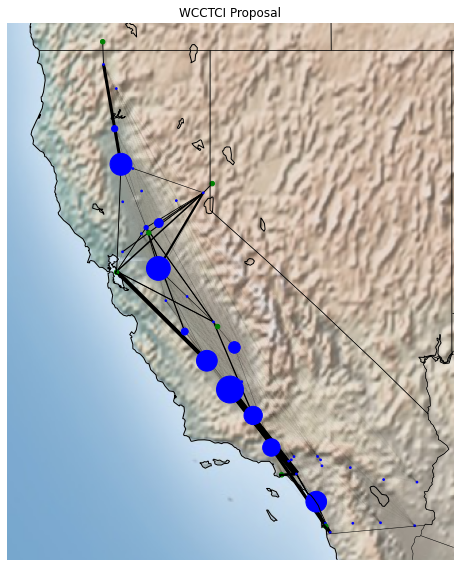

<Figure size 432x288 with 0 Axes>

In [66]:
m = Basemap(
        projection='merc',
        llcrnrlon=-125 ,
        llcrnrlat=32,
        urcrnrlon=-114,
        urcrnrlat=42.5,
        lat_ts=0,
        resolution='i',
        suppress_ticks=True)

G = res.station_demand_g
sim_index = 50
#colors
for node in G.nodes:
    G.nodes[node]["color"] = "blue"
    G.nodes[node]["size"] = 3
for node in nx.get_node_attributes(G,'demand'):
    G.nodes[node]["color"] = "green"
    G.nodes[node]["size"] = 20
node_color = nx.get_node_attributes(G,'color').values() 
node_size = {node: edge_totals[sim_index][(node, node)]*3 if (node, node) in edge_totals[sim_index] else G.nodes[node]["size"] for node in G.nodes}
widths = {edge:edge_totals[sim_index][edge]/100*2 if edge in edge_totals[sim_index] else .002 for edge in G.edges}
pos = nx.get_node_attributes(G,'pos')
for key in pos.keys():
    pos[key] = (m(pos[key][0], pos[key][1]))
    
fig = plt.subplots(figsize=(8 ,10))
nx.draw(G, pos = pos, node_size = list(node_size.values()), width= list(widths.values()), node_color=node_color, arrows=False)

m.drawcountries()
m.drawstates()
m.drawcoastlines()
m.shadedrelief() #etopo() 
plt.title('WCCTCI Proposal')
plt.show()
plt.savefig(f'figures/{fname}.png')

<Figure size 432x288 with 0 Axes>

In [31]:
# Based on res.get_number_vehicles() but need to specify the simulation index retrospectively

#Get vehicles along a given edge (all battery levels)
h_i = np.linspace(0,23,24)*5 # Simulation index on the hour
for i in h_i:
    paths = {}
    # Count vehicles counts along edges
    for vehicle in res.vehicle_list: # iterate over all vehicles in the simulation
        vehicle_location = vehicle.segmented_path[i] 
        if vehicle_location in paths:
            paths[vehicle_location]+=1
        else:
            paths[vehicle_location]=1
            
    break


AttributeError: 'Vehicle' object has no attribute 'segmented_path'

### WCCTCI Stations

As we get metrics for the runs we can weight nodes accordingly. Can also prune edges and add those but right now they are too long to make the visualization insightful. 

In [13]:
stations = pd.read_csv('../../Data/simulation_networks/wcctci_stations.csv')
stations["physical_capacity"] = 8
stations["charging_rate"] = 45
stations.to_csv('../../Data/simulation_networks/wcctci_stations-updated.csv')
distances = pd.read_csv('../../Data/simulation_networks/wcctci_distances.csv')

In [14]:
# add nodes with IDs, charging_rates, positions
station_G  = nx.DiGraph()
for index, row in stations.iterrows():
    station_G.add_node(str(row["OID_"]), 
                        pos = (row["SnapX"],  row["SnapY"]),
                        physical_capacity = row["physical_capacity"])

# TODO: elevation, avg_speed data
for index, row in distances.iterrows():
    station_G.add_edge(str(row["OriginID"]),str(row["DestinationID"]),
                    weight= row["Total_TruckTravelTime"]/60,
                    time = row["Total_TruckTravelTime"]/60,
                    length= row["Total_Kilometers"],
                    battery_cost = row["Total_Kilometers"]*1.9/215*100) # battery cost as a percent of total battery capacity consumed (assuming battery capacity of 215kWh)


In [15]:
# Remove edges that are too long
long_r = [(a,b) for a, b, attrs in station_G.edges(data=True) if (attrs["battery_cost"] >= 150) | (attrs["battery_cost"] == 0)]
station_G.remove_edges_from(long_r)

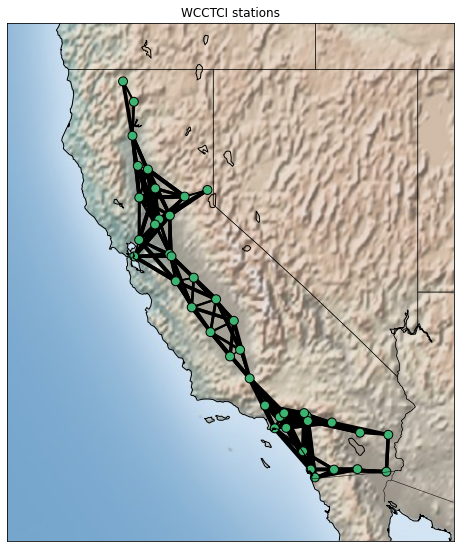

In [16]:
m = Basemap(
        projection='merc',
        llcrnrlon=-126 ,
        llcrnrlat=31,
        urcrnrlon=-113,
        urcrnrlat=43,
        lat_ts=0,
        resolution='i',
        suppress_ticks=True)

# convert lat and lon to map projection
pos = {}
for index, row in stations.iterrows():
    pos[str(row["OID_"])] = (m(row["SnapX"],  row["SnapY"]))

fig = plt.subplots(figsize=(8 ,10))
# The NetworkX part
cap = []
for i in list(station_G.nodes(data=True)):
    cap.append(i[1]['physical_capacity']*10)
    
widths = []
for j in list(station_G.edges(data=True)):
    widths.append(j[2]['weight']*2)

    
# draw
nx.draw_networkx(station_G,pos,node_size=cap,width=widths, with_labels=False, arrows=False, node_color='mediumseagreen', edgecolors='black')

# Now draw the map
m.drawcountries()
m.drawstates()
m.drawcoastlines()
m.shadedrelief() #etopo() 
plt.title('WCCTCI stations')
plt.show()

In [17]:
pos

{'1': (996235.1453704847, 205184.08689070493),
 '2': (785173.3841446992, 525931.7901862762),
 '3': (658299.4107347036, 675812.8491434376),
 '4': (545917.3077670748, 840532.599516964),
 '5': (491897.0824029494, 1040791.3088256908),
 '6': (423018.45491184836, 1214089.211399591),
 '7': (375063.25637900806, 1487700.3276430764),
 '8': (957967.0109974054, 289708.7495562141),
 '9': (903592.7385673618, 365738.24229240464),
 '10': (835040.2003433203, 438051.0935422797),
 '11': (721590.4621875006, 596962.4127993896),
 '12': (597617.1452800726, 755826.9793475862),
 '13': (525411.1698666948, 928713.8237600927),
 '14': (427720.1357811509, 1111360.1612427435),
 '15': (405644.3976573659, 1311656.3967603506),
 '16': (410139.666947653, 1421574.0286341752),
 '17': (982862.5890592143, 230843.79267896898),
 '18': (1058220.3562444556, 230576.91044558492),
 '19': (1134134.6280139685, 231908.8640730474),
 '20': (1227899.7062730945, 223792.70232390612),
 '21': (889574.2496896685, 404301.16078864876),
 '22': (

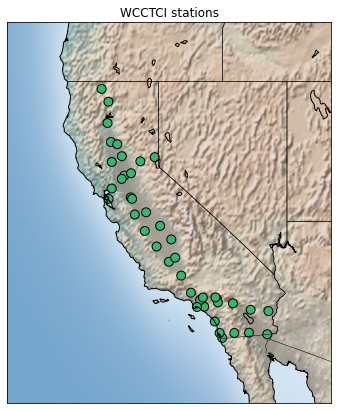

In [6]:
m = Basemap(
        projection='merc',
        llcrnrlon=-127 ,
        llcrnrlat=30,
        urcrnrlon=-112,
        urcrnrlat=44,
        lat_ts=0,
        resolution='i',
        suppress_ticks=True)

# convert lat and lon to map projection
pos = {}
for index, row in stations.iterrows():
    pos[str(row["OID_"])] = (m(row["SnapX"],  row["SnapY"]))

fig = plt.subplots(figsize=(6 ,7))
# The NetworkX part
cap = []
for i in list(station_G.nodes(data=True)):
    cap.append(i[1]['physical_capacity']*10)
    
# draw
nx.draw_networkx_nodes(station_G,pos,node_size=cap,node_color='mediumseagreen', edgecolors='black')

# Now draw the map
m.drawcountries()
m.drawstates()
m.drawcoastlines()
m.shadedrelief() #etopo() 
plt.title('WCCTCI stations')
plt.show()

In [51]:
# m.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels = 12000, verbose= True)

### Parking

In [39]:
stations = pd.read_csv('../Data/simulation_networks/public_parking_stations.csv')
stations["physical_capacity"] = 8
stations["charging_rate"] = 45
# stations.to_csv('../Data/simulation_networks/wcctci_stations-updated.csv')
distances = pd.read_csv('../Data/simulation_networks/public_parking_distances.csv')

In [40]:
# add nodes with IDs, charging_rates, positions
station_G  = nx.DiGraph()
for index, row in stations.iterrows():
    station_G.add_node(str(row["OID_"]), 
                        pos = (row["SnapX"],  row["SnapY"]),
                        physical_capacity = row["physical_capacity"])

# TODO: elevation, avg_speed data
for index, row in distances.iterrows():
    station_G.add_edge(str(row["OriginID"]),str(row["DestinationID"]),
                    weight= row["Total_TruckTravelTime"]/60,
                    time = row["Total_TruckTravelTime"]/60,
                    length= row["Total_Kilometers"],
                    battery_cost = row["Total_Kilometers"]*1.9/215*100) # battery cost as a percent of total battery capacity consumed (assuming battery capacity of 215kWh)


In [41]:
# Remove edges that are too long
long_r = [(a,b) for a, b, attrs in station_G.edges(data=True) if (attrs["battery_cost"] >= 150) | (attrs["battery_cost"] == 0)]
station_G.remove_edges_from(long_r)

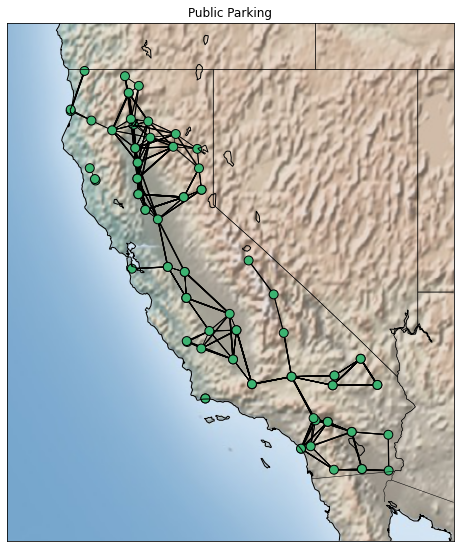

In [43]:
m = Basemap(
        projection='merc',
        llcrnrlon=-126 ,
        llcrnrlat=31,
        urcrnrlon=-113,
        urcrnrlat=43,
        lat_ts=0,
        resolution='i',
        suppress_ticks=True)

# convert lat and lon to map projection
pos = {}
for index, row in stations.iterrows():
    pos[str(row["OID_"])] = (m(row["SnapX"],  row["SnapY"]))

fig = plt.subplots(figsize=(8 ,10))
# The NetworkX part
cap = []
for i in list(station_G.nodes(data=True)):
    cap.append(i[1]['physical_capacity']*10)
    
widths = []
for j in list(station_G.edges(data=True)):
    widths.append(j[2]['weight']*0.7)

    
# draw
nx.draw_networkx(station_G,pos,node_size=cap,width=widths, with_labels=False, arrows=False, node_color='mediumseagreen', edgecolors='black')

# Now draw the map
m.drawcountries()
m.drawstates()
m.drawcoastlines()
m.shadedrelief() #etopo() 
plt.title('Public Parking')
plt.show()